In [1]:
%load_ext autoreload
%autoreload 2
import torch
qm_data = torch.load('./qm9_data_noar.pt')

In [2]:
import sys
sys.path = ['../codes/'] + sys.path
from model_vae import GraphVAE, decoder, encoder, decoderUL
device = 'cpu'

In [6]:
en = encoder(10, 3)

In [7]:
from torch_geometric.data import DataLoader
data_loader = DataLoader(qm_data, batch_size=64, shuffle=True, follow_batch=['edge_index'])


/home/user/miniconda3/envs/gnn/lib/python3.9/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [8]:
en = en.to(device)

In [11]:
dn = decoderUL(128, 128, 128, 9, 10, 3, hidden_dims=[[128, 128], [128, 256], [256]], \
               edge_hidden_dim=32, 
               device=device, attr_bn=-1, edge_out_dim=64, fix_points=[1, 1], roll_ones=[0, 3]).to(device)

In [12]:
vae = GraphVAE(en, dn, 9, decode_type='ul', adj_loss='adjbce', device=device)

In [14]:
from train_vae import train_ul, train_ul_v2

In [ ]:
train_ul(data_loader, vae, 150, device=device, debug=True, separate_update=True, moving_ave=True)

In [75]:
h_data = []
vae.eval()
jj = 0
for j in data_loader:
    jj += 1
    x, edge_attr, edge_index, batch, edge_batch = \
    j.x, j.edge_attr, j.edge_index, j.batch, j.edge_index_batch
    if not hasattr(vae, 'decode_type'):
        vae.decode_type = 'adj'
    num_batches = max(batch) + 1
    num_index = torch.zeros(num_batches, dtype=torch.long)
    for j in range(num_batches):
        num_index[j] = (batch <= j).sum()
    input_features, adj, attr_tensor = vae.generate_adj(x, edge_index, edge_attr, batch, edge_batch, num_index)
    graph_h = vae.encoder(x, edge_index, edge_attr, batch, edge_batch)
    h_data.append(graph_h)
    if jj > 100:
        break

In [76]:
tot_h_data = torch.cat(h_data, axis=0)

In [78]:
from graphvae.util_molecular import MolFromTorchGraphData, evaluate, MolFromTorchGraphData_enriched
from graphvae.unpool_utils import convert_Batch_to_datalist
from torch_geometric.data import Data, Batch
import torch.nn.functional as F
from rdkit import RDLogger    
from torch_geometric.data import Data
RDLogger.DisableLog('rdApp.*')

mol_data = torch.load('../../unpool/qm9_smiles_noar.pt')

evaluate_num = 10000
batch_size = 128
z_dim = 128
dnul = vae.decoder
dnul.eval()
hard = True
tau = 1


In [79]:
all_res = []
dnul.eval()
with torch.no_grad():

    for j in range(1):
        eval_fake_data = []
        problem_info = []
        for j in range(evaluate_num//batch_size):
            # Use new randoms..
            z_rand = torch.randn(batch_size, vae.decoder.in_dim)*tot_h_data.std(axis=0).unsqueeze(0) + tot_h_data.mean(axis=0).unsqueeze(0)
            z = z_rand.to(device)
            res2 = dnul(z)
            x, g_edge_attr, g_edge_index, g_batch, g_edge_batch = res2[:-3]

            g_edge_attr = torch.softmax(g_edge_attr, dim=-1)
            out1 = torch.softmax(x[:, :4], dim=-1)
            out2 = torch.softmax(x[:, 4:7], dim=-1)
            out3 = torch.softmax(x[:, 7:10], dim=-1)

            xs1 = F.gumbel_softmax(torch.log(out1), dim=1, hard=hard, tau=tau)
            xs2 = F.gumbel_softmax(torch.log(out2), dim=1, hard=hard, tau=tau)
            xs3 = F.gumbel_softmax(torch.log(out3), dim=1, hard=hard, tau=tau)
            g_edge_attr = F.gumbel_softmax(torch.log(g_edge_attr), dim=1, hard=hard, tau=tau)
            out_features = torch.cat([xs1, xs2, xs3], axis=1)

            fake_data = convert_Batch_to_datalist(x=out_features, edge_index=g_edge_index, edge_attr=g_edge_attr, batch=g_batch, edge_batch=g_edge_batch)
            fake_data = Batch.from_data_list(\
                [Data(x=j.x, edge_index=j.edge_index, edge_attr=j.edge_attr) \
                        for j in fake_data], \
                        follow_batch=['edge_index'])
            eval_fake_data.extend([fake_data[j] for j in range(fake_data.batch.max().item() + 1)])

        eval_fake_data = [MolFromTorchGraphData_enriched(j.to('cpu'), node_dim=4, without_aroma=True) for j in eval_fake_data]
        eval_res = evaluate(eval_fake_data, mol_data, eval_two=True)
        print (eval_res)
        all_res.append(eval_res)

Uniqueness at 1k, 10k 0.984 0.9424868367760226
(0.7418870192307693, 0.9424868367760226, 0.9459962756052142)


In [72]:
all_res = []
dnul.eval()
with torch.no_grad():

    for j in range(100):
        eval_fake_data = []
        problem_info = []
        for j in range(evaluate_num//batch_size):
            # Use new randoms..
            z_rand = torch.randn(batch_size, vae.decoder.in_dim)*tot_h_data.std(axis=0).unsqueeze(0) + tot_h_data.mean(axis=0).unsqueeze(0)
            z = z_rand.to(device)
            res2 = dnul(z)
            x, g_edge_attr, g_edge_index, g_batch, g_edge_batch = res2[:-3]

            g_edge_attr = torch.softmax(g_edge_attr, dim=-1)
            out1 = torch.softmax(x[:, :4], dim=-1)
            out2 = torch.softmax(x[:, 4:7], dim=-1)
            out3 = torch.softmax(x[:, 7:10], dim=-1)

            xs1 = F.gumbel_softmax(torch.log(out1), dim=1, hard=hard, tau=tau)
            xs2 = F.gumbel_softmax(torch.log(out2), dim=1, hard=hard, tau=tau)
            xs3 = F.gumbel_softmax(torch.log(out3), dim=1, hard=hard, tau=tau)
            g_edge_attr = F.gumbel_softmax(torch.log(g_edge_attr), dim=1, hard=hard, tau=tau)
            out_features = torch.cat([xs1, xs2, xs3], axis=1)

            fake_data = convert_Batch_to_datalist(x=out_features, edge_index=g_edge_index, edge_attr=g_edge_attr, batch=g_batch, edge_batch=g_edge_batch)
            fake_data = Batch.from_data_list(\
                [Data(x=j.x, edge_index=j.edge_index, edge_attr=j.edge_attr) \
                        for j in fake_data], \
                        follow_batch=['edge_index'])
            eval_fake_data.extend([fake_data[j] for j in range(fake_data.batch.max().item() + 1)])

        eval_fake_data = [MolFromTorchGraphData_enriched(j.to('cpu'), node_dim=4, without_aroma=True) for j in eval_fake_data]
        eval_res = evaluate(eval_fake_data, mol_data, eval_two=True)
        print (eval_res)
        all_res.append(eval_res)

Uniqueness at 1k, 10k 0.986 0.9435351882160393
(0.734375, 0.9435351882160393, 0.9551893610870194)
Uniqueness at 1k, 10k 0.986 0.9436946148602591
(0.7346754807692307, 0.9436946148602591, 0.9505923143600116)
Uniqueness at 1k, 10k 0.994 0.9352016404647984
(0.7326722756410257, 0.9352016404647984, 0.9469375822248209)
Uniqueness at 1k, 10k 0.983 0.9425648021828104
(0.7341746794871795, 0.9425648021828104, 0.9509335649153279)
Uniqueness at 1k, 10k 0.981 0.9326663061114115
(0.7407852564102564, 0.9326663061114115, 0.9494056248187881)
Uniqueness at 1k, 10k 0.987 0.939319393193932
(0.7328725961538461, 0.939319393193932, 0.949949076094864)
Uniqueness at 1k, 10k 0.992 0.9434217650243638
(0.7399839743589743, 0.9434217650243638, 0.951506456241033)
Uniqueness at 1k, 10k 0.985 0.942019099590723
(0.7341746794871795, 0.942019099590723, 0.9477190441708907)
Uniqueness at 1k, 10k 0.985 0.9391458589166326
(0.7340745192307693, 0.9391458589166326, 0.9507482202527967)
Uniqueness at 1k, 10k 0.985 0.93809784094014

In [73]:
torch.save(vae, 'ULVAE_QM9.pt')


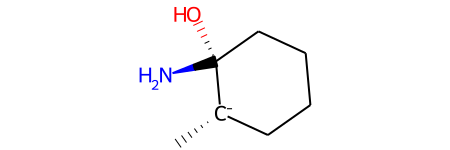

In [51]:
eval_fake_data[1021]

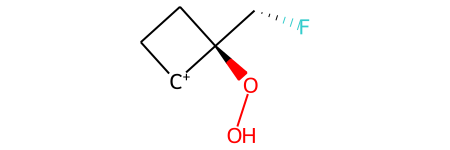

In [53]:
eval_fake_data[21]

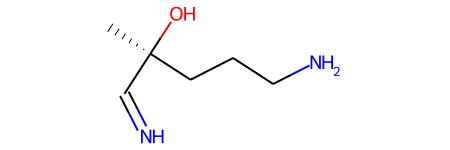

In [54]:
eval_fake_data[2]